Project 9 - Transfer Learning

Overview:

In this problem we use "Transfer Learning" of an Object Detector model to detect any object according to the problem in hand.

1. To use already trained model, we will import the model and its supporting files for the model to function.    
   
2. Set the parameters for the model      
3. Import the dataset for the model to train on. For this, we are using the WIDER FACE dataset.       
4. Get the labels for these images, so that we can use this information while training for detecting faces with the given model using transfer learning. 
(5 points)
5. Making the model ready for training by freezing some layers in which we are not updating the weights while training. We need to train the top 6-7 layers. (10 points)     
6. load the weights of the Mobile Net model given in file ''`mobilenet_1_0_224_tf.h5`''      
7. Set the optimizers, loss functions, epochs, learning rate, batch size, check pointing, early stopping etc. (5 points)     
8. Train the model      
9. Load the best saved weights (5 points)     
10. Predict using test images (5 points)  


In [0]:
# Mounting the google drive..

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
# Extracting the files given for the project...

In [0]:
files_zip_path = "/content/drive/My Drive/DLCP/Files_required_for_face_detection.zip"

import zipfile
#This extracts the files to the current working directory
archive = zipfile.ZipFile(files_zip_path, 'r')
archive.extractall()
!ls

dataset				 predictor.py
drive				 sample_data
face_generator.py		 ssd_box_encode_decode_utils.py
face_generator.pyc		 ssd_box_encode_decode_utils.pyc
keras_layer_AnchorBoxes.py	 ssd_mobilenet_face_epoch_25_loss0.0916.h5
keras_layer_AnchorBoxes.pyc	 wider_extract.py
keras_layer_L2Normalization.py	 WIDER_train
keras_layer_L2Normalization.pyc  wider_train_small.npy
keras_ssd_loss.py		 wider_train_v1.npy
keras_ssd_loss.pyc		 WIDER_val
mn_model.py			 wider_val_small.npy
mn_model.pyc			 wider_val_v1.npy
mobilenet_1_0_224_tf.h5


In [0]:
### Importing MobileNet model given in file `mn_model.py`
from mn_model import mn_model

Using TensorFlow backend.


In [0]:
#### Import the BatchGenerator and SSDLoss functions as well, used in MobileNet model
import warnings
warnings.filterwarnings("ignore")

from face_generator import BatchGenerator
from keras_ssd_loss import SSDLoss
from ssd_box_encode_decode_utils import SSDBoxEncoder, decode_y, decode_y2

In [0]:
from keras.optimizers import Adam, SGD, Nadam
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, TensorBoard, LearningRateScheduler
from keras.callbacks import Callback
from keras import backend as K 
from keras.models import load_model
from math import ceil 
import numpy as np 
from termcolor import colored

from mn_model import mn_model
from face_generator import BatchGenerator
from keras_ssd_loss import SSDLoss
from ssd_box_encode_decode_utils import SSDBoxEncoder, decode_y, decode_y2

# training parameters
from keras import backend as K
import scipy.misc as sm

## Set the parameters for the model

#### We need to customize the model parameters according to our problem as given below.

#### Set n_classes (no.of classes) = 2, as we are interested in only face detection. 
#### `Face` will be one class and everything else comes under other class (we can call it as `background`)

#### Set class_names = ["background", "face"]

In [0]:
img_height =512
img_width = 512

img_channels = 3

n_classes =2 
class_names = ["background","face"]

scales = [0.07, 0.15, 0.33, 0.51, 0.69, 0.87, 1.05] # anchorboxes for coco dataset
aspect_ratios = [[0.5, 1.0, 2.0],
                 [1.0/3.0, 0.5, 1.0, 2.0, 3.0],
                 [1.0/3.0, 0.5, 1.0, 2.0, 3.0],
                 [1.0/3.0, 0.5, 1.0, 2.0, 3.0],
                 [0.5, 1.0, 2.0],
                 [0.5, 1.0, 2.0]] # The anchor box aspect ratios used in the original SSD300
two_boxes_for_ar1 = True
limit_boxes = True # Whether or not you want to limit the anchor boxes to lie entirely within the image boundaries
variances = [0.1, 0.1, 0.2, 0.2] # The variances by which the encoded target coordinates are scaled as in the original implementation
coords = 'centroids' # Whether the box coordinates to be used as targets for the model should be in the 'centroids' or 'minmax' format, see documentation
normalize_coords = True

#Path where you want to save the weights, model and checkpoints
det_model_path = "./"

### Now, we have imported the model and its dependencies. The next thing is to import the dataset for the model to train on. For this, we are using the WIDER FACE dataset. 




In [0]:
# Setting the project path, train images & test images path...

In [0]:
project_path = "/content/drive/My Drive/DLCP/"

In [0]:
train_images_path = project_path + 'WIDER_train.zip'
test_images_path = project_path + 'WIDER_val.zip'

In [0]:
import zipfile
#This extracts the files to the current working directory
archive = zipfile.ZipFile(train_images_path, 'r')
archive.extractall()

In [0]:
archive = zipfile.ZipFile(test_images_path, 'r')
archive.extractall()

### Now, the images are available. The next thing we need is to get the labels for these images, so that we can use this information while training for detecting faces with the given model using transfer learning. 


In [0]:
# Loading the data..

In [0]:
data = np.load('./wider_train_small.npy', allow_pickle=True ).item()

In [0]:
### Printed first element to check the above given information.
# data contains lot of keys
for key in data:
    print key
    print data[key]
    #Breaking after printing first key and its value
    break

52--Photographers/52_Photographers_photographertakingphoto_52_582.jpg
['WIDER_train/images/52--Photographers/52_Photographers_photographertakingphoto_52_582.jpg', 'WIDER_train/images/52--Photographers/52_Photographers_photographertakingphoto_52_582.jpg', [300, 300], [[21, 667, 9, 655], 1]]


In [0]:
##  As we can see from the above output all the information mentioned above is there for all the images.

In [0]:
### Now, load the files `wider_trian.npy` and `wider_val.npy`

In [0]:
train_data = 'wider_train_small.npy'
test_data = 'wider_val_small.npy'

x = np.load(train_data, allow_pickle=True)

### Now, call the imported model with the given parameters and freeze all the layers in the model with names not having ''`detection`'' word as prefix.

As we are not training the model from scratch, we are freezing all the above layers in the model having only last few layers while training to update their weights according to the problem in hand. This is called as **Transfer Learning**.

In [0]:
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()

W1115 06:45:12.530354 140067182139264 deprecation.py:323] From /usr/local/lib/python2.7/dist-packages/tensorflow_core/python/compat/v2_compat.py:68: disable_resource_variables (from tensorflow.python.ops.variable_scope) is deprecated and will be removed in a future version.
Instructions for updating:
non-resource variables are not supported in the long term


In [0]:
# build the keras model
# this model is not pre-trained, we are doing it from scratch 

K.clear_session()
#The following function returns you multiple things. The "model" is the Keras model that has to be trained 
model, model_layer, img_input, predictor_sizes = mn_model(image_size=(img_height, img_width, img_channels), 
                                                                      n_classes = n_classes,
                                                                      min_scale = None, 
                                                                      max_scale = None, 
                                                                      scales = scales, 
                                                                      aspect_ratios_global = None, 
                                                                      aspect_ratios_per_layer = aspect_ratios, 
                                                                      two_boxes_for_ar1= two_boxes_for_ar1, 
                                                                      limit_boxes=limit_boxes, 
                                                                      variances= variances, 
                                                                      coords=coords, 
                                                                      normalize_coords=normalize_coords)

#model.summary()  #Un-comment this line to view the details of the model and all layers present in the model..

W1115 06:54:35.697647 140469674608512 module_wrapper.py:139] From /usr/local/lib/python2.7/dist-packages/keras/backend/tensorflow_backend.py:95: The name tf.reset_default_graph is deprecated. Please use tf.compat.v1.reset_default_graph instead.

W1115 06:54:35.702960 140469674608512 module_wrapper.py:139] From /usr/local/lib/python2.7/dist-packages/keras/backend/tensorflow_backend.py:98: The name tf.placeholder_with_default is deprecated. Please use tf.compat.v1.placeholder_with_default instead.

W1115 06:54:35.715342 140469674608512 module_wrapper.py:139] From /usr/local/lib/python2.7/dist-packages/keras/backend/tensorflow_backend.py:102: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W1115 06:54:35.718916 140469674608512 module_wrapper.py:139] From /usr/local/lib/python2.7/dist-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W1115 06:54:35.727595 14

====> Model Specific data
====> Height, Width, Channels : 512 512 3


W1115 06:54:36.382736 140469674608512 module_wrapper.py:139] From /usr/local/lib/python2.7/dist-packages/keras/backend/tensorflow_backend.py:1834: The name tf.nn.fused_batch_norm is deprecated. Please use tf.compat.v1.nn.fused_batch_norm instead.



In [0]:
for layer_key in model_layer:
  if('detection'  not in layer_key): #prefix detection to freeze layers which does not have detection
    model_layer[layer_key].trainable = False
print (colored("classification layers freezed", 'green'))

classification layers freezed


After making the model ready for transfer learning, loading the weights of the model given in file ''mobilenet_1_0_224_tf.h5''


In [0]:
print ("loading classification weights")
classification_model = project_path+'mobilenet_1_0_224_tf.h5'
model.load_weights(classification_model,  by_name= True)

loading classification weights


In [0]:
#### Using the functions given in the model, we are trying to divide the dataset into train and validation samples.

In [0]:
#!pip install numpy==1.16.2
import numpy as np
print(np.__version__)

1.16.2


In [0]:
batch_size = 32
ssd_box_encoder = SSDBoxEncoder(img_height=img_height,
                                img_width=img_width,
                                n_classes=n_classes, 
                                predictor_sizes=predictor_sizes,
                                min_scale=None,
                                max_scale=None,
                                scales=scales,
                                aspect_ratios_global=None,
                                aspect_ratios_per_layer=aspect_ratios,
                                two_boxes_for_ar1=two_boxes_for_ar1,
                                limit_boxes=limit_boxes,
                                variances=variances,
                                pos_iou_threshold=0.5,
                                neg_iou_threshold=0.2,
                                coords=coords,
                                normalize_coords=normalize_coords)

train_dataset = BatchGenerator(images_path=train_data, 
                include_classes='all', 
                box_output_format = ['class_id', 'xmin', 'xmax', 'ymin', 'ymax'])

print ("==>TRAINING DATA")
print ("==> Parsing XML files ...")

train_dataset.parse_xml(
                  annotations_path=train_data,
                  image_set_path='None',
                  image_set='None',
                  classes = class_names, 
                  exclude_truncated=False,
                  exclude_difficult=False,
                  ret=False, 
                  debug = False)
print("==>Parsing XML Finished.")

print ("==>Generate training batches...")
train_generator = train_dataset.generate(
                 batch_size=batch_size,
                 train=True,
                 ssd_box_encoder=ssd_box_encoder,
                 equalize=True,
                 brightness=(0.5,2,0.5),
                 flip=0.5,
                 translate=((0, 20), (0, 30), 0.5),
                 scale=(0.75, 1.2, 0.5),
                 crop=False,
                 #random_crop = (img_height,img_width,1,3), 
                 random_crop=False,
                 resize=(img_height, img_width),
                 #resize=False,
                 gray=False,
                 limit_boxes=True,
                 include_thresh=0.4,
                 diagnostics=False)

print ("==>Training batch generation complete")

n_train_samples = train_dataset.get_n_samples()

print ("==>Total number of training samples = {}".format(n_train_samples))

# Now repeat above steps for validation data 

print ("==>VALIDATION")

val_dataset = BatchGenerator(images_path=test_data, include_classes='all', 
                box_output_format = ['class_id', 'xmin', 'xmax', 'ymin', 'ymax'])

print ("==> Parsing XML files ...")


val_dataset.parse_xml(
                  annotations_path=test_data,
                  image_set_path='None',
                  image_set='None',
                  classes = class_names, 
                  exclude_truncated=False,
                  exclude_difficult=False,
                  ret=False, 
                  debug = False)


print("==>Parsing XML Finished.")


print ("==>Generate training batches...")
val_generator = val_dataset.generate(
                 batch_size=batch_size,
                 train=True,
                 ssd_box_encoder=ssd_box_encoder,
                 equalize=False,
                 brightness=False,
                 flip=False,
                 translate=False,
                 scale=False,
                 crop=False,
                 #random_crop = (img_height,img_width,1,3), 
                 random_crop=False, 
                 resize=(img_height, img_width), 
                 #resize=False, 
                 gray=False,
                 limit_boxes=True,
                 include_thresh=0.4,
                 diagnostics=False)


print ("==>Training batch generation complete")

n_val_samples = val_dataset.get_n_samples()

print ("==>Total number of validation samples = {}".format(n_val_samples))


==>TRAINING DATA
==> Parsing XML files ...
==>Parsing XML Finished.
==>Generate training batches...
==>Training batch generation complete
==>Total number of training samples = 128
==>VALIDATION
==> Parsing XML files ...
==>Parsing XML Finished.
==>Generate training batches...
==>Training batch generation complete
==>Total number of validation samples = 60


Now, lets setup things for training by initilaizing required variables like learning rate, epochs, optimizer and loss function(SSDLoss) to compile the model

In [0]:
# setting up training 

# batch_size and no.of epochs

batch_size = 16
num_epochs = 10

#Learning rate
base_lr = 0.002

# Optimizer
adam = Adam(lr=base_lr, beta_1=0.9, beta_2=0.999, epsilon=1e-6, decay = 0.0)

# Loss
ssd_loss = SSDLoss(neg_pos_ratio=2, n_neg_min=0, alpha=1.0, beta = 1.0)

# Compile
model.compile(optimizer=adam, loss=ssd_loss.compute_loss)

W1115 06:55:18.315524 140469674608512 module_wrapper.py:139] From /usr/local/lib/python2.7/dist-packages/keras/optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.

W1115 06:55:18.332561 140469674608512 module_wrapper.py:139] From keras_ssd_loss.py:97: The name tf.log is deprecated. Please use tf.math.log instead.

W1115 06:55:18.338058 140469674608512 deprecation.py:323] From keras_ssd_loss.py:129: to_float (from tensorflow.python.ops.math_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use `tf.cast` instead.
W1115 06:55:18.351222 140469674608512 deprecation.py:323] From keras_ssd_loss.py:76: where (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
W1115 06:55:18.369862 140469674608512 deprecation.py:323] From keras_ssd_loss.py:162: to_int32 (from tensorf

Lets add early stopping and model checkpoint layers on validation loss with some patience values and using fit_generator function to train the model on data generated batch-by-batch by a Python generator, train_generator object as generator.
We are using checkpoint to save the best model based on validation accuracy.

In [0]:
early_stopping = EarlyStopping(monitor='val_loss', min_delta=0.001, patience=100)
model_checkpoint =  ModelCheckpoint(det_model_path + 'ssd_mobilenet_face_epoch_{epoch:02d}_loss{val_loss:.4f}.h5',
                                                           monitor='val_loss',
                                                           verbose=1,
                                                           save_best_only=True,
                                                           save_weights_only=True,
                                                           mode='auto',
                                                           period=1)

print ("training starting...")
history = model.fit_generator(generator = train_generator,
                              steps_per_epoch = ceil(n_train_samples/batch_size)*2,
                              epochs = num_epochs,
                              callbacks = [model_checkpoint, early_stopping],                      
                              validation_data = val_generator,
                              validation_steps = ceil(n_val_samples/batch_size))

model.save_weights(det_model_path + 'ssd_mobilenet_weights_epoch_{}.h5'.format(num_epochs))

print ("model and weight files saved at : " + det_model_path)

training starting...


W1115 06:55:30.866080 140469674608512 module_wrapper.py:139] From /usr/local/lib/python2.7/dist-packages/keras/backend/tensorflow_backend.py:986: The name tf.assign_add is deprecated. Please use tf.compat.v1.assign_add instead.

W1115 06:55:32.243247 140469674608512 module_wrapper.py:139] From /usr/local/lib/python2.7/dist-packages/keras/backend/tensorflow_backend.py:973: The name tf.assign is deprecated. Please use tf.compat.v1.assign instead.



Epoch 1/10
16/16 [==============================] - 51s 3s/step - loss: 0.3273 - val_loss: 0.3316

Epoch 00001: val_loss improved from inf to 0.33164, saving model to ./ssd_mobilenet_face_epoch_01_loss0.3316.h5
Epoch 2/10
16/16 [==============================] - 13s 838ms/step - loss: 0.2527 - val_loss: 0.2788

Epoch 00002: val_loss improved from 0.33164 to 0.27876, saving model to ./ssd_mobilenet_face_epoch_02_loss0.2788.h5
Epoch 3/10
16/16 [==============================] - 31s 2s/step - loss: 0.2318 - val_loss: 0.2471

Epoch 00003: val_loss improved from 0.27876 to 0.24709, saving model to ./ssd_mobilenet_face_epoch_03_loss0.2471.h5
Epoch 4/10
16/16 [==============================] - 31s 2s/step - loss: 0.2215 - val_loss: 0.2535

Epoch 00004: val_loss did not improve from 0.24709
Epoch 5/10
16/16 [==============================] - 31s 2s/step - loss: 0.2160 - val_loss: 0.2400

Epoch 00005: val_loss improved from 0.24709 to 0.23996, saving model to ./ssd_mobilenet_face_epoch_05_loss0

In [0]:
## Load the best saved model from above step and check predictions for test data using test_generator object to generate batches.
 model_path = './'
 model_name = 'ssd_mobilenet_face_epoch_09_loss0.2135.h5'

model.load_weights(project_path + model_name,  by_name= True)

print (colored('weights %s loaded' % (project_path + model_name), 'green'))


weights /content/drive/My Drive/DLCP/ssd_mobilenet_face_epoch_09_loss0.2135.h5 loaded


Plotting the boundingbox in the test image to show the predictions.


In [0]:
def save_bb(path, filename, results, prediction=True):
  
  # print filename

  img = image.load_img(filename, target_size=(img_height, img_width))
  img = image.img_to_array(img)

  filename = filename.split("/")[-1]

  if(not prediction):
    filename = filename[:-4] + "_gt" + ".jpg"

  #fig,currentAxis = plt.subplots(1)
  currentAxis = plt.gca()

 # Get detections with confidence higher than 0.6.
  colors = plt.cm.hsv(np.linspace(0, 1, 25)).tolist()
  color_code = min(len(results), 16)
  print (colored("total number of bbs: %d" % len(results), "yellow"))
  for result in results:
    # Parse the outputs.

    if(prediction):
      det_label = result[0]
      det_conf = result[1]
      det_xmin = result[2]
      det_xmax = result[3]
      det_ymin = result[4]
      det_ymax = result[5]
    else :
      det_label = result[0]
      det_xmin = result[1]
      det_xmax = result[2]
      det_ymin = result[3]
      det_ymax = result[4]

    xmin = int(det_xmin)
    ymin = int(det_ymin)
    xmax = int(det_xmax)
    ymax = int(det_ymax)

    if(prediction):
      score = det_conf
    
    plt.imshow(img / 255.)
    
    label = int(int(det_label))
    label_name = class_names[label]
    # print label_name 
    # print label

    if(prediction):
      display_txt = '{:0.2f}'.format(score)
    else:
      display_txt = '{}'.format(label_name)

      
    # print (xmin, ymin, ymin, ymax)
    coords = (xmin, ymin), (xmax-xmin), (ymax-ymin)
    color_code = color_code-1 
    color = colors[color_code]
    currentAxis.add_patch(plt.Rectangle(*coords, fill=False, edgecolor=color, linewidth=2))
    currentAxis.text(xmin, ymin, display_txt, bbox={'facecolor':color, 'alpha':0.2})

  # y
  currentAxis.axes.get_yaxis().set_visible(False)
  # x
  currentAxis.axes.get_xaxis().set_visible(False)
  plt.savefig(path + filename, bbox_inches='tight')

  print ('saved' , path + filename)

  plt.clf()


Create a folder with name output_test and get the predictions for the test images using model.predict()

In [0]:
!mkdir output_test

In [0]:
from keras.preprocessing import image
from matplotlib import pyplot as plt

test_size = 10
test_generator = val_dataset.generate(
                 batch_size=test_size,
                 train=False,
                 ssd_box_encoder=ssd_box_encoder,
                 equalize=False,
                 brightness=False,
                 flip=False,
                 translate=False,
                 scale=False,
                 crop=False,
                 #random_crop = (img_height,img_width,1,3), 
                 random_crop=False, 
                 resize=(img_height, img_width), 
                 #resize=False,
                 gray=False,
                 limit_boxes=True,
                 include_thresh=0.4,
                 diagnostics=False)

print (colored("done.", "green"))

print (colored("now predicting...", "yellow"))

_CONF = 0.60 
_IOU = 0.15

for i in range(test_size):
  X, y, filenames = next(test_generator)

  y_pred = model.predict(X)


  y_pred_decoded = decode_y2(y_pred,
                             confidence_thresh=_CONF,
                            iou_threshold=_IOU,
                            top_k='all',
                            input_coords=coords,
                            normalize_coords=normalize_coords,
                            img_height=img_height,
                            img_width=img_width)


  np.set_printoptions(suppress=True)

  save_bb("./output_test/", filenames[i], y_pred_decoded[i])
  save_bb("./output_test/", filenames[i], y[i], prediction=False)


done.
now predicting...
total number of bbs: 4
('saved', './output_test/35_Basketball_basketballgame_ball_35_998.jpg')
total number of bbs: 26
('saved', './output_test/35_Basketball_basketballgame_ball_35_998_gt.jpg')
total number of bbs: 3
('saved', './output_test/49_Greeting_peoplegreeting_49_50.jpg')
total number of bbs: 3
('saved', './output_test/49_Greeting_peoplegreeting_49_50_gt.jpg')
total number of bbs: 0
('saved', './output_test/4_Dancing_Dancing_4_97.jpg')
total number of bbs: 5
('saved', './output_test/4_Dancing_Dancing_4_97_gt.jpg')
total number of bbs: 5
('saved', './output_test/22_Picnic_Picnic_22_10.jpg')
total number of bbs: 4
('saved', './output_test/22_Picnic_Picnic_22_10_gt.jpg')
total number of bbs: 1
('saved', './output_test/49_Greeting_peoplegreeting_49_589.jpg')
total number of bbs: 1
('saved', './output_test/49_Greeting_peoplegreeting_49_589_gt.jpg')
total number of bbs: 4
('saved', './output_test/12_Group_Large_Group_12_Group_Large_Group_12_354.jpg')
total num

<Figure size 432x288 with 0 Axes>

## Visualize a test image to check predictions


In [0]:
  from google.colab.patches import cv2_imshow

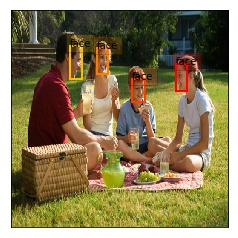

In [0]:
import cv2
img = cv2.imread('./output_test/22_Picnic_Picnic_22_10_gt.jpg',cv2.IMREAD_UNCHANGED)
assert not isinstance(img,type(None)), 'image not found'
cv2_imshow(img)

Populating the interactive namespace from numpy and matplotlib


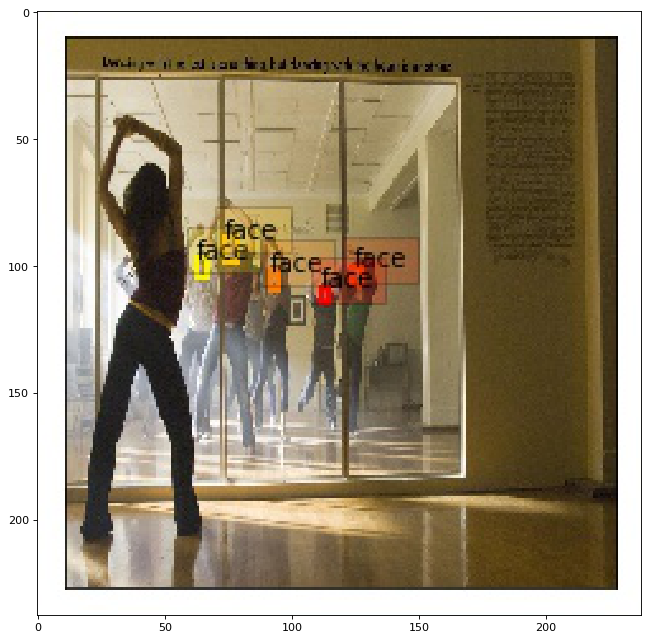

In [0]:
%pylab inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
img=mpimg.imread('./output_test/4_Dancing_Dancing_4_97_gt.jpg')
from matplotlib.pyplot import figure
figure(num=None, figsize=(10, 10), dpi=80, facecolor='w', edgecolor='k')
imgplot = plt.imshow(img)
plt.show()

Conclusion:

- We used already trained model(Transfer Learning) MobileNet model in our project
- Imported the dataset for the model from Wider face dataset
- freezing all the layers in the model with names not having ''detection'' word as prefix.
- Loaded the weights of the Mobile Net model given in the file mobilenet_1_0_224_tf.h5
- Trained the model by initilaizing required variables like learning rate, epochs, optimizer and loss function(SSDLoss) to compile the model
- Loaded the best saved model and checked the predictions for test data using test_generator object to generate batches.
- Successfully predicted the test images using the trained model by Visualization steps.

Thus all the project objectives & steps were covered and the required goals achieved.